# 2020-01-26

Try to determine topics based on extended dataset of comments that I have now (including the list of channels that I curated)

In [104]:
import os
import re
import numpy as np
import pandas as pd
from pprint import pprint
import random
from textblob import TextBlob
import time

# Gensim
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel

# spacy for lemmatization
import spacy

from tqdm import tqdm_notebook as tqdm

# Plotting tools
import pyLDAvis
import pyLDAvis.gensim  # don't skip this
import matplotlib.pyplot as plt
%matplotlib inline

# Enable logging for gensim - optional
import logging
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.ERROR)

import warnings
warnings.filterwarnings("ignore",category=DeprecationWarning)

### Load up the data we will need (comments, video and channel info):

In [2]:

insight_dir = 'C:\\Users\\Ronald Maj\\Documents\\GitHub\\InsightDataProject\\'

#comms1_df = pd.read_csv(insight_dir+'data\\processed\\comments_df.csv', index_col=0, low_memory=False)
#comms2_df = pd.read_csv(insight_dir+'data\\processed\\comments_df2.csv', index_col=0, low_memory=False)
#comms3_df = pd.read_csv(insight_dir+'data\\processed\\comments_df3.csv', index_col=0, low_memory=False)
#comms4_df = pd.read_csv(insight_dir+'data\\processed\\comments_df4.csv', index_col=0, low_memory=False)

#comms_df = pd.concat([comms1_df,comms2_df,comms3_df,comms4_df], ignore_index=True)

In [3]:
# Save to .csv for easy loading next time:
# comms_df.to_csv(insight_dir+'data\\processed\\all_comments_df.csv')

# Load .csv file with all comments:
#comms_df = pd.read_csv(insight_dir+'data\\processed\\all_comments_df.csv')

C:\ProgramData\Anaconda3\envs\insight\lib\site-packages\IPython\core\interactiveshell.py:3051: DtypeWarning: Columns (8) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [4]:
#vids1_df = pd.read_csv(insight_dir+'data\\processed\\videos_top30_df.csv', index_col=0)
#vids2_df = pd.read_csv(insight_dir+'data\\processed\\videos_next_set_df.csv', index_col=0)
#vids3_df = pd.read_csv(insight_dir+'data\\processed\\videos_manulist_df.csv', index_col=0)

#vids_df = pd.concat([vids1_df, vids2_df, vids3_df], ignore_index=True)

In [8]:
# Save to .csv for easy loading next time:
#vids_df.to_csv(insight_dir+'data\\processed\\all_vids_df.csv')

# Load .csv file with all comments:
#vids_df = pd.read_csv(insight_dir+'data\\processed\\all_vids_df.csv')

In [9]:
# Just take one channel as a test
#test_cid = channels_df.iloc[1]['ChannelID']
#test_vids_list = list(vids_df[vids_df['ChannelID'] == test_cid]['VidID'])

# Get just the comments from the test case
#test_df = comms_df[comms_df['videoId'].isin(test_vids_list)]

In [10]:
from langdetect import detect

In [11]:
#vids_df = vids_df.dropna(subset=['VidDescription'])

In [16]:
#lang_detect = []
#non_en_idxs = []
#non_lang_idxs = []
#for idx,descr in enumerate(vids_df['VidDescription']):
#    try:
#        if detect(vids_df['VidDescription'].iloc[idx]) != 'en':
#            non_en_idxs.append(idx)
#    except:
#        print('Index: '+str(idx)+' Description: '+str(descr))
#        non_lang_idxs.append(idx)

#lang_detects = [detect(descr) ]

Index: 942 Description: https://www.donationalerts.com/r/kanutoshka
Index: 1983 Description: http://colindecolinde.blogspot.com/
Index: 1984 Description: http://colindecolinde.blogspot.com/
Index: 1985 Description: http://colindecolinde.blogspot.com/
Index: 1986 Description: http://colindecolinde.blogspot.com/
Index: 1987 Description: http://colindecolinde.blogspot.com/


In [17]:
#non_en_idxs[0:5]

[144, 365, 642, 644, 645]

In [18]:
#non_en_idxs = non_en_idxs + non_lang_idxs

In [33]:
#non_en_idxs.sort()

In [35]:
#non_en_idxs.reverse()

In [36]:
#non_en_idxs[0:5]

[4693, 4651, 4386, 4241, 4179]

In [37]:
#vids_df.iloc[4693]

Unnamed: 0                                                     4944
VidID                                                   IVZsfc0TqJo
ChannelID                                  UCi9cDo6239RAzPpBZO9y5SA
VidTitle              Lele Pons - Vete Pa La (Official Music Video)
VidDescription    Vete Pa La (Spotify) ▶ https://spoti.fi/2rbtP8...
VidPublished                               2019-12-06T17:00:11.000Z
viewCount                                               1.43113e+07
likeCount                                                    421945
dislikeCount                                                  15520
favoriteCount                                                     0
commentCount                                                  14568
Name: 4944, dtype: object

In [39]:
#for idx in non_en_idxs:
#    vids_df = vids_df.drop(vids_df.index[idx])

In [56]:
#vids_df.to_csv(insight_dir+'data\\processed\\all_vids_en_df.csv')
vids_df = pd.read_csv(insight_dir+'data\\processed\\all_vids_en_df.csv')

In [47]:
#en_vid_ids = list(set(vids_df['VidID']))

In [48]:
#comms_df.columns

Index(['Unnamed: 0', 'CommID', 'authorChannelId', 'authorChannelUrl',
       'authorDisplayName', 'authorProfileImageUrl', 'canRate', 'likeCount',
       'moderationStatus', 'parentId', 'publishedAt', 'textDisplay',
       'textOriginal', 'updatedAt', 'videoId', 'viewerRating'],
      dtype='object')

In [52]:
#len(comms_df)

966910

In [53]:
#len(comms_df[comms_df['videoId'].isin(en_vid_ids)])

935901

In [54]:
#comms_df = comms_df[comms_df['videoId'].isin(en_vid_ids)]

In [55]:
#comms_df.to_csv(insight_dir+'data\\processed\\all_comments_en_df.csv')
comms_df = pd.read_csv(insight_dir+'data\\processed\\all_comments_en_df.csv')

### Pre-processing

In [57]:
# Load test
commtext = comms_df['textDisplay']

# Convert to list
data = commtext.values.tolist()

# Check simple function works:
for idx,comm in enumerate(data):
    try:
        re.sub('\S*@\S*\s?', '', comm)
    except:
        print('Index Number: '+str(idx)+' Comment:'+str(comm))


Index Number: 151955 Comment:nan
Index Number: 179204 Comment:nan
Index Number: 180968 Comment:nan
Index Number: 182130 Comment:nan


In [58]:
# Need to clean up the original comment data set as there are nan's present
comms_df.iloc[206584]

Unnamed: 0                                                          235107
CommID                                          UgzTpxnfKid321BJWuB4AaABAg
authorChannelId                      {'value': 'UCepGxTn14dnrg5dsTudxv_A'}
authorChannelUrl         http://www.youtube.com/channel/UCepGxTn14dnrg5...
authorDisplayName                                             Tricia Mulan
authorProfileImageUrl    https://yt3.ggpht.com/a/AGF-l7_GGbYt5JkBa_IJZF...
canRate                                                               True
likeCount                                                                0
moderationStatus                                                       NaN
parentId                                                                 0
publishedAt                                       2019-12-15T19:51:44.000Z
textDisplay              I'm the same with caffeine. I don't like takin...
textOriginal             I'm the same with caffeine. I don't like takin...
updatedAt                

In [59]:
comms_df = comms_df.dropna(subset=['textDisplay'])

In [63]:
# Cleaning
def deEmojify(inputString):
    return inputString.encode('ascii', 'ignore').decode('ascii')

def clean_text(text):
    # lower case:
    text = text.lower()
    # replace new line and return with space
    text = text.replace("\n", " ").replace("\r"," ")
    # replace punctuation marks with space
    punc_list = '!"#$%&()*+,-./:;<=>?@[\]{}|^_~' + '0123456789'
    t=str.maketrans(dict.fromkeys(punc_list, " "))
    text = text.translate(t)
    # replace single quote with empty character
    t = str.maketrans(dict.fromkeys("'`",""))
    text = text.translate(t)
    return text

# Get comments
commtext = comms_df['textDisplay']

# Convert to list
data = commtext.values.tolist()

# Remove Emails/handles
data = [re.sub('\S*@\S*\s?', '', comm) for comm in data]

# Apply cleaning
data = [clean_text(comm) for comm in data]

# Remove emojis
data = [deEmojify(comm) for comm in data]

In [68]:
data[0:5]

['did i just watch two brothers legit have a  toss  to split a tiebreak  ',
 'vlogs i thought that was a joke  lol',
 'bahahahahaha',
 'lmao true   ps   ill edit it',
 'adam brothers  and the worst part about it is that they arent even tasmanian ']

In [71]:
# NLTK Stop words function
from nltk.corpus import stopwords
stop_words = stopwords.words('english')
stop_words.extend(['s'])


# Conver the list of sentences to list of lists of words (in each sentece)
def sent_to_words(sentences):
    for sentence in sentences:
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))  # deacc=True removes punctuations

# Define functions for stopwords, bigrams, trigrams and lemmatization
def remove_stopwords(texts):
    return [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts]

def make_bigrams(texts):
    return [bigram_mod[doc] for doc in texts]

def make_trigrams(texts):
    return [trigram_mod[bigram_mod[doc]] for doc in texts]

def lemmatization(texts, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
    """https://spacy.io/api/annotation"""
    texts_out = []
    for sent in texts:
        doc = nlp(" ".join(sent)) 
        texts_out.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])
    return texts_out

In [72]:
data_words = list(sent_to_words(data))

print(data_words[0])

# Build the bigram and trigram models
bigram = gensim.models.Phrases(data_words, min_count=5, threshold=100) # higher threshold fewer phrases.
trigram = gensim.models.Phrases(bigram[data_words], threshold=100)  

# Faster way to get a sentence clubbed as a trigram/bigram
bigram_mod = gensim.models.phrases.Phraser(bigram)
trigram_mod = gensim.models.phrases.Phraser(trigram)

['did', 'just', 'watch', 'two', 'brothers', 'legit', 'have', 'toss', 'to', 'split', 'tiebreak']
['lachie', 'its', 'me', 'josh', 'lmao', 'what', 'are', 'the', 'odds', 'you', 'watch', 'shammi']


In [ ]:

print(data_lemmatized[0:5])

In [ ]:


# View
print(corpus[0:5])

In [ ]:
# Remove Stop Words
data_words_nostops = remove_stopwords(data_words)

# Form Bigrams
data_words_bigrams = make_bigrams(data_words_nostops)

# Initialize spacy 'en' model, keeping only tagger component (for efficiency)
# python3 -m spacy download en
nlp = spacy.load('en', disable=['parser', 'ner'])

# Do lemmatization keeping only noun, adj, vb, adv
data_lemmatized = lemmatization(data_words_bigrams, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV'])

In [73]:
# Create Dictionary
id2word = corpora.Dictionary(data_lemmatized)

# Create Corpus
texts = data_lemmatized

# Term Document Frequency
corpus = [id2word.doc2bow(text) for text in texts]

# Build LDA model
lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=15, 
                                           random_state=100,
                                           update_every=1,
                                           chunksize=100,
                                           passes=10,
                                           alpha='auto',
                                           per_word_topics=True)

# Print the Keyword in the 15 topics
pprint(lda_model.print_topics())
doc_lda = lda_model[corpus]

KeyboardInterrupt: 

In [82]:
id2word[2]

'split'

In [76]:
data_words[-1]

['had',
 'dream',
 'that',
 'met',
 'hila',
 'and',
 'started',
 'crying',
 'from',
 'excitement']

In [83]:
data_lemmatized

[['watch', 'brother', 'legit', 'toss', 'split', 'tiebreak'],
 ['vlog', 'think', 'joke', 'lol'],
 ['bahahahahaha'],
 ['lmao', 'true', 'ps', 'ill', 'edit'],
 ['adam', 'brother', 'bad', 'part', 'be', 'not', 'even', 'tasmanian'],
 ['fart', 'lethal'],
 ['burgess', 'fishing', 'fact'],
 ['think', 'smelt'],
 ['point'],
 ['do', 'not', 'see', 'end', 'come'],
 ['lachie', 'josh', 'lmao', 'odd', 'watch', 'shammi'],
 ['shammi', 'vlog', 'mate'],
 ['least', 'happy', 'ending'],
 [],
 ['make', 'play', 'word'],
 ['think', 'get', 'shammi', 'be', 'dad'],
 ['hahaha'],
 ['take', 'minute', 'watch', 'sec', 'brother', 'pretend', 'whack'],
 ['pretend'],
 ['last', 'challenge', 'makin_memorie', 'love', 'content', 'shammi'],
 ['good', 'time', 'mate', 'haha'],
 ['brother', 'make', 'memory'],
 ['s', 'memory', 'want'],
 [],
 ['dark', 'ending'],
 ['be',
  'go',
  'buy',
  'shit',
  'friend',
  'good',
  'memory',
  'shirt',
  'wear',
  'last',
  'day',
  'school',
  'free',
  'dress',
  'see',
  'mate',
  'teacher',
  

In [93]:
twenty_k_list = random.sample(data_lemmatized,20000)

In [99]:
empty_idxs =[]
for idx,item in enumerate(twenty_thousand_list):
    if item == []:
        empty_idxs.append(idx)

In [98]:
[] in twenty_k_list

True

In [101]:
len(empty_idxs)

778

Start with the 20k version of comments (not 950k that is total):

In [103]:
def quick_lda_learn(number_items):
    print('Number of items is: '+str(number_items))
    k_list = random.sample(data_lemmatized,number_items)
    # Create Dictionary
    id2word = corpora.Dictionary(k_list)

    # Create Corpus
    texts = k_list

    # Term Document Frequency
    corpus = [id2word.doc2bow(text) for text in texts]

    # Build LDA model
    lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                               id2word=id2word,
                                               num_topics=15, 
                                               random_state=100,
                                               update_every=1,
                                               chunksize=100,
                                               passes=10,
                                               alpha='auto',
                                               per_word_topics=True)

    # Print the Keyword in the 15 topics
    pprint(lda_model.print_topics())
    doc_lda = lda_model[corpus]

[(0,
  '0.123*"day" + 0.081*"lol" + 0.050*"show" + 0.046*"bad" + 0.043*"cry" + '
  '0.039*"miss" + 0.037*"phil" + 0.031*"person" + 0.031*"world" + '
  '0.030*"change"'),
 (1,
  '0.189*"never" + 0.084*"stuff" + 0.074*"stop" + 0.035*"move" + '
  '0.027*"interesting" + 0.000*"sunscreen" + 0.000*"label" + '
  '0.000*"fragrance_free" + 0.000*"instead" + 0.000*"store"'),
 (2,
  '0.152*"good" + 0.101*"have" + 0.054*"even" + 0.045*"ever" + 0.043*"still" + '
  '0.039*"wait" + 0.036*"that" + 0.030*"like" + 0.029*"kid" + 0.028*"call"'),
 (3,
  '0.098*"literally" + 0.083*"first" + 0.055*"funny" + 0.039*"cut" + '
  '0.038*"month" + 0.037*"buy" + 0.037*"true" + 0.035*"grow" + 0.034*"awesome" '
  '+ 0.034*"turn"'),
 (4,
  '0.224*"get" + 0.192*"s" + 0.068*"guy" + 0.043*"friend" + 0.042*"talk" + '
  '0.040*"mean" + 0.032*"old" + 0.029*"lmao" + 0.018*"anyone" + '
  '0.018*"favorite"'),
 (5,
  '0.100*"say" + 0.097*"look" + 0.061*"time" + 0.042*"happy" + 0.041*"always" '
  '+ 0.039*"omg" + 0.038*"can" + 0

In [107]:
# Visualize the topics
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(lda_model, corpus, id2word)
vis

C:\ProgramData\Anaconda3\envs\insight\lib\site-packages\pyLDAvis\_prepare.py:257: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  return pd.concat([default_term_info] + list(topic_dfs))


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
11    -0.307628 -0.321968       1        1  22.016548
6     -0.300077  0.324249       2        1  20.886616
5     -0.152543  0.005142       3        1  12.849675
2     -0.042851  0.000890       4        1   8.069549
4     -0.040681  0.000844       5        1   7.516809
13     0.018350 -0.000204       6        1   5.179723
0      0.040477 -0.000496       7        1   4.560412
10     0.062408 -0.000744       8        1   3.695915
3      0.085078 -0.000962       9        1   3.230019
12     0.085711 -0.000968      10        1   3.178223
8      0.084568 -0.000958      11        1   3.087066
9      0.088494 -0.000992      12        1   2.942809
7      0.114706 -0.001191      13        1   1.695349
1      0.124847 -0.001254      14        1   1.044928
14     0.139143 -0.001387      15        1   0.046346, topic_info=     Category         Freq              Term        Total  loglift  logprob
0     Default  4695.000000              love  4695.000000  30.0000   30.000
3     Default  4578.000000                be  4578.000000  29.0000   29.000
21    Default  2526.000000               get  2526.000000  28.0000   28.000
71    Default  4252.000000               not  4252.000000  27.0000   27.000
26    Default  2160.000000                 s  2160.000000  26.0000   26.000
...       ...          ...               ...          ...      ...      ...
5964  Topic15     0.003866              camp     1.295823   1.8621   -9.795
5966  Topic15     0.003866          leanamae     1.295774   1.8621   -9.795
5973  Topic15     0.003866  gingerbread_hous     1.295774   1.8621   -9.795
5967  Topic15     0.003866             outro     1.296396   1.8616   -9.795
5968  Topic15     0.003866              vedo     1.295775   1.8621   -9.795

[1297 rows x 6 columns], token_table=      Topic      Freq      Term
term                           
61        6  0.983843    actual
313       6  0.997175  actually
374      10  0.987308       ago
1156      1  0.994104     agree
366      12  0.958930       air
...     ...       ...       ...
31        2  0.998971     would
332      10  0.999130      year
1612      6  0.987675     young
514       2  0.996309   youtube
888       4  0.994425  youtuber

[297 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[12, 7, 6, 3, 5, 14, 1, 11, 4, 13, 9, 10, 8, 2, 15])

In [108]:
sponsor_comms = []
for sent in data_lemmatized:
    if 'sponsor' in sent:
        sponsor_comms.append(sent)

In [109]:
len(sponsor_comms)

855

In [110]:
len(data_lemmatized)

935897

In [112]:
(len(sponsor_comms)/len(data_lemmatized))*100

0.09135620693302789

In [116]:
def quick_lda_learn(number_items):
    start_time = time.time()
    print('Number of items is: '+str(number_items))
    k_list = random.sample(data_lemmatized,number_items)
    # Create Dictionary
    id2word = corpora.Dictionary(k_list)

    # Create Corpus
    texts = k_list

    # Term Document Frequency
    corpus = [id2word.doc2bow(text) for text in texts]

    # Build LDA model
    lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                               id2word=id2word,
                                               num_topics=15, 
                                               random_state=100,
                                               update_every=1,
                                               chunksize=100,
                                               passes=10,
                                               alpha='auto',
                                               per_word_topics=True)

    # Print the Keyword in the 15 topics
    #pprint(lda_model.print_topics())
    doc_lda = lda_model[corpus]
    end_time = time.time()
    print('Run time: '+str(end_time-start_time))
    return doc_lda,id2word,lda_model,corpus



In [119]:
doc_lda,id2word,lda_model,corpus = quick_lda_learn(100)

Number of items is: 100
Run time: 0.44281649589538574


In [136]:
doc_lda,id2word,lda_model,corpus = quick_lda_learn(1000)

Number of items is: 1000
Run time: 2.259244680404663


In [137]:
# Visualize the topics
start_t = time.time()
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(lda_model, corpus, id2word)
end_t = time.time()
vis

C:\ProgramData\Anaconda3\envs\insight\lib\site-packages\pyLDAvis\_prepare.py:257: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  return pd.concat([default_term_info] + list(topic_dfs))


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
2      0.390750  0.018759       1        1  23.003738
14    -0.018594  0.216410       2        1   9.548755
1     -0.026249  0.073182       3        1   8.979246
3     -0.017321 -0.140284       4        1   8.386828
5      0.056654 -0.073087       5        1   7.768992
6     -0.049145  0.104870       6        1   7.341948
7     -0.021122 -0.099347       7        1   6.265341
8     -0.040012 -0.027848       8        1   6.099683
10    -0.028562 -0.037488       9        1   5.220074
13    -0.046529  0.011853      10        1   4.832161
12    -0.047312  0.004284      11        1   4.185868
11    -0.033057 -0.014673      12        1   3.446323
0     -0.040551 -0.014661      13        1   2.681349
9     -0.040669 -0.012360      14        1   1.605050
4     -0.038281 -0.009611      15        1   0.634647, topic_info=     Category        Freq      Term       Total  loglift  logprob
346   Default  114.000000     video  114.000000  30.0000  30.0000
25    Default  180.000000       not  180.000000  29.0000  29.0000
267   Default  181.000000        be  181.000000  28.0000  28.0000
55    Default  177.000000      love  177.000000  27.0000  27.0000
19    Default   75.000000         s   75.000000  26.0000  26.0000
...       ...         ...       ...         ...      ...      ...
557   Topic15    0.015907      burn    0.993204   0.9257  -7.9603
953   Topic15    0.016051     share    1.012719   0.9152  -7.9513
608   Topic15    0.015925  remember    0.998335   0.9216  -7.9592
738   Topic15    0.015886     night    1.005684   0.9119  -7.9617
1373  Topic15    0.015886     carry    0.991420   0.9261  -7.9617

[519 rows x 6 columns], token_table=      Topic      Freq        Term
term                             
53       11  0.842629  absolutely
678       6  0.888404    actually
380       5  0.871854         add
78        3  0.904337         ago
409       7  0.753902       alfie
...     ...       ...         ...
187       5  0.756967         yea
123       1  0.974118        year
124       3  0.971287       young
950       1  0.933552     youtube
204       5  0.939898         zoe

[332 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[3, 15, 2, 4, 6, 7, 8, 9, 11, 14, 13, 12, 1, 10, 5])

In [138]:
print('Time for vis of 1k corpus: '+str((end_t - start_t)/60)+' min')

Time for vis of 1k corpus: 1.236509871482849 min


In [139]:
doc_lda,id2word,lda_model,corpus = quick_lda_learn(3000)

Number of items is: 3000
Run time: 8.208044528961182


In [140]:
# Visualize the topics
start_t = time.time()
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(lda_model, corpus, id2word)
end_t = time.time()
vis

C:\ProgramData\Anaconda3\envs\insight\lib\site-packages\pyLDAvis\_prepare.py:257: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  return pd.concat([default_term_info] + list(topic_dfs))


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
1     -0.455027 -0.058687       1        1  31.785810
11    -0.039907  0.363714       2        1  11.078315
10     0.005807 -0.018125       3        1   7.903139
14     0.002074 -0.015203       4        1   7.826355
12     0.028407 -0.024592       5        1   5.983869
9      0.021578 -0.022737       6        1   5.799393
0      0.035982 -0.025608       7        1   4.987594
2      0.037946 -0.025399       8        1   4.807666
7      0.041957 -0.025273       9        1   4.332565
3      0.047827 -0.025398      10        1   3.357570
5      0.050414 -0.025043      11        1   3.138236
13     0.054856 -0.024644      12        1   2.853214
4      0.055819 -0.024421      13        1   2.153422
6      0.054167 -0.024674      14        1   2.053967
8      0.058100 -0.023910      15        1   1.938883, topic_info=     Category        Freq        Term       Total  loglift  logprob
22    Default  598.000000        love  598.000000  30.0000  30.0000
63    Default  322.000000       video  322.000000  29.0000  29.0000
157   Default  258.000000         get  258.000000  28.0000  28.0000
1     Default  686.000000          be  686.000000  27.0000  27.0000
13    Default  679.000000         not  679.000000  26.0000  26.0000
...       ...         ...         ...         ...      ...      ...
3181  Topic15    0.049393       study    1.131020   0.8120  -9.0665
677   Topic15    0.049348      change    1.136899   0.8059  -9.0674
1116  Topic15    0.049285      course    1.124167   0.8159  -9.0687
3595  Topic15    0.049281  university    1.123379   0.8165  -9.0688
1666  Topic15    0.049281       worth    1.121046   0.8186  -9.0688

[562 rows x 6 columns], token_table=      Topic      Freq        Term
term                             
370       2  0.949580  absolutely
131       3  0.925411         act
29        4  0.971690    actually
473       8  0.866202    adorable
65        9  0.939467      almost
...     ...       ...         ...
140       3  0.980996        work
130       1  0.986027       world
28        5  0.996343       would
586       1  0.992499        year
417       1  0.985403     youtube

[312 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[2, 12, 11, 15, 13, 10, 1, 3, 8, 4, 6, 14, 5, 7, 9])

In [141]:
print('Time for vis of 3k corpus: '+str((end_t - start_t)/60)+' min')

Time for vis of 3k corpus: 2.529065402348836 min


In [142]:
doc_lda,id2word,lda_model,corpus = quick_lda_learn(7000)

Number of items is: 7000
Run time: 22.83812379837036


In [143]:
# Visualize the topics
start_t = time.time()
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(lda_model, corpus, id2word)
end_t = time.time()
vis

C:\ProgramData\Anaconda3\envs\insight\lib\site-packages\pyLDAvis\_prepare.py:257: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  return pd.concat([default_term_info] + list(topic_dfs))


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
14    -0.236303 -0.288546       1        1  11.061666
13    -0.117552  0.033829       2        1  11.012815
11    -0.120016  0.036520       3        1  10.989517
7     -0.193542  0.280977       4        1  10.941187
4     -0.030079  0.003356       5        1   9.667353
3     -0.009739  0.000274       6        1   8.922629
9      0.039533 -0.005248       7        1   8.217505
8      0.061398 -0.006806       8        1   6.465230
5      0.070374 -0.007346       9        1   6.011211
10     0.079394 -0.007795      10        1   4.727650
6      0.083762 -0.007997      11        1   4.590439
2      0.090871 -0.008199      12        1   3.672773
1      0.094979 -0.007962      13        1   1.729120
0      0.094709 -0.007805      14        1   1.685117
12     0.092213 -0.007252      15        1   0.305782, topic_info=     Category         Freq    Term        Total  loglift  logprob
18    Default  1491.000000      be  1491.000000  30.0000  30.0000
28    Default  1362.000000     not  1362.000000  29.0000  29.0000
2     Default  1362.000000    love  1362.000000  28.0000  28.0000
26    Default   939.000000      do   939.000000  27.0000  27.0000
269   Default   698.000000    good   698.000000  26.0000  26.0000
...       ...          ...     ...          ...      ...      ...
1358  Topic15     0.014074     gay     1.301369   1.2632  -9.3235
680   Topic15     0.014074    fuck     1.301909   1.2628  -9.3235
1464  Topic15     0.014104   share     1.327095   1.2458  -9.3213
647   Topic15     0.014074   level     1.305772   1.2598  -9.3235
2035  Topic15     0.014067  upload     1.309033   1.2568  -9.3240

[607 rows x 6 columns], token_table=      Topic      Freq        Term
term                             
585       1  0.967125  absolutely
568      11  0.992306    actually
350      11  0.970404         age
405       5  0.966428         ago
162       4  0.980059       agree
...     ...       ...         ...
41        1  0.997183       would
397       9  0.992317       wrong
61        5  0.996852        year
557       6  0.992517     youtube
604       2  0.972919    youtuber

[313 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[15, 14, 12, 8, 5, 4, 10, 9, 6, 11, 7, 3, 2, 1, 13])

In [144]:
print('Time for vis of 7k corpus: '+str((end_t - start_t)/60)+' min')

Time for vis of 7k corpus: 4.764942415555319 min


In [145]:
doc_lda,id2word,lda_model,corpus = quick_lda_learn(10000)

Number of items is: 10000
Run time: 38.36156988143921


In [146]:
# Visualize the topics
start_t = time.time()
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(lda_model, corpus, id2word)
end_t = time.time()
vis

C:\ProgramData\Anaconda3\envs\insight\lib\site-packages\pyLDAvis\_prepare.py:257: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  return pd.concat([default_term_info] + list(topic_dfs))


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
5      0.374907  0.229682       1        1  20.998154
1      0.170938 -0.354674       2        1  13.064763
2      0.079834 -0.048497       3        1  10.403245
13     0.047782 -0.020444       4        1  10.093200
0      0.066232 -0.035040       5        1   9.872660
14    -0.023842  0.013186       6        1   6.745689
6     -0.033863  0.016309       7        1   5.973137
9     -0.045804  0.019391       8        1   5.886954
3     -0.057146  0.021992       9        1   5.071127
11    -0.076616  0.025337      10        1   3.761649
4     -0.076907  0.025324      11        1   3.270858
12    -0.102646  0.027566      12        1   2.026484
7     -0.102667  0.027520      13        1   1.697615
10    -0.106960  0.027146      14        1   1.071621
8     -0.113241  0.025202      15        1   0.062840, topic_info=     Category         Freq        Term        Total  loglift  logprob
54    Default  2283.000000        love  2283.000000  30.0000   30.000
1     Default  2515.000000          be  2515.000000  29.0000   29.000
31    Default  1282.000000       video  1282.000000  28.0000   28.000
148   Default  1102.000000         get  1102.000000  27.0000   27.000
8     Default  1960.000000         not  1960.000000  26.0000   26.000
...       ...          ...         ...          ...      ...      ...
3926  Topic15     0.003987        hone     1.224860   1.6449   -9.367
3925  Topic15     0.003987  homeschool     1.224864   1.6449   -9.367
3924  Topic15     0.003987       focus     1.233859   1.6375   -9.367
3923  Topic15     0.003987  curriculum     1.226025   1.6439   -9.367
3922  Topic15     0.003987       co_op     1.224860   1.6449   -9.367

[1380 rows x 6 columns], token_table=      Topic      Freq        Term
term                             
411      12  0.548840    absolute
244      12  0.983663  absolutely
0         2  0.985227     account
327      12  0.964859      actual
19       10  0.993485    actually
...     ...       ...         ...
300       7  0.985572       wrong
89       11  0.998184        year
847       2  0.992509       young
243      10  0.995234     youtube
274      12  0.983939    youtuber

[302 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[6, 2, 3, 14, 1, 15, 7, 10, 4, 12, 5, 13, 8, 11, 9])

In [147]:
print('Time for vis of 10k corpus: '+str((end_t - start_t)/60)+' min')

Time for vis of 10k corpus: 4.899798560142517 min


In [124]:
doc_lda,id2word,lda_model,corpus = quick_lda_learn(20000)

Number of items is: 20000
Run time: 111.92093706130981


In [129]:
doc_lda,id2word,lda_model,corpus = quick_lda_learn(30000)

Number of items is: 30000
Run time: 205.5199475288391


In [130]:
# Visualize the topics
start_t = time.time()
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(lda_model, corpus, id2word)
end_t = time.time()
vis

C:\ProgramData\Anaconda3\envs\insight\lib\site-packages\pyLDAvis\_prepare.py:257: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  return pd.concat([default_term_info] + list(topic_dfs))


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
14     0.431111 -0.068252       1        1  14.760367
13     0.029529  0.410666       2        1   8.714734
0     -0.001956 -0.011965       3        1   8.030848
8     -0.007766 -0.019128       4        1   8.012394
9      0.002193 -0.005082       5        1   7.632867
1      0.008963  0.009468       6        1   7.515472
6     -0.006837 -0.018243       7        1   7.345736
11    -0.043887 -0.035950       8        1   6.111853
2     -0.044840 -0.036417       9        1   5.817257
4     -0.049103 -0.037275      10        1   5.598199
7     -0.054568 -0.037663      11        1   5.000396
5     -0.059869 -0.038355      12        1   4.839224
10    -0.064569 -0.038251      13        1   4.349118
3     -0.059943 -0.038121      14        1   4.287303
12    -0.078458 -0.035431      15        1   1.984231, topic_info=     Category         Freq     Term        Total  loglift  logprob
78    Default  7064.000000       be  7064.000000  30.0000  30.0000
32    Default  6188.000000     love  6188.000000  29.0000  29.0000
6     Default  5978.000000      not  5978.000000  28.0000  28.0000
236   Default  3887.000000    video  3887.000000  27.0000  27.0000
5     Default  3678.000000       do  3678.000000  26.0000  26.0000
...       ...          ...      ...          ...      ...      ...
789   Topic15     0.077535    wanna     1.533663   0.9352 -10.9624
1126  Topic15     0.077488    intro     1.522332   0.9421 -10.9630
1328  Topic15     0.077514    wrong     1.530900   0.9368 -10.9627
1075  Topic15     0.077481    sweet     1.537481   0.9321 -10.9631
725   Topic15     0.077477  exactly     1.544772   0.9273 -10.9632

[618 rows x 6 columns], token_table=      Topic      Freq        Term
term                             
714       1  0.997017  absolutely
13       12  0.989917         act
912       7  0.997956    actually
282      11  0.992866    adorable
489      10  0.991909         age
...     ...       ...         ...
309      11  0.999193        year
442       5  0.996326         yet
337      12  0.998523     youtube
302       4  0.994158    youtuber
1720     15  0.985286         zoe

[323 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[15, 14, 1, 9, 10, 2, 7, 12, 3, 5, 8, 6, 11, 4, 13])

In [135]:
print('Time for vis of 30k corpus: '+str((end_t - start_t)/60)+' min')

Time for vis of 30k corpus: 10.687468016147614 min


In [125]:
no_items = [100,1000,3000,7000,10000,20000]
run_times = [0.44281649589538574,2.1401593685150146,7.6138653755187,22.393683433532715,37.498425006866455,111.92093706130981]

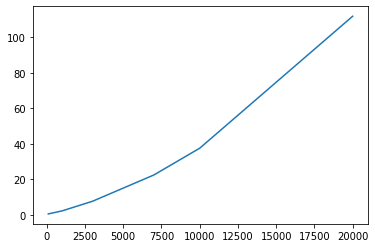

In [127]:
import matplotlib.pyplot as plt
plt.plot(no_items,run_times)

Try with spaCy

In [148]:
# Get comments
commtext = comms_df['textDisplay']

# Convert to list
data_spa = commtext.values.tolist()

# Remove Emails/handles
data_spa = [re.sub('\S*@\S*\s?', '', comm) for comm in data_spa]

In [149]:
# Remove emojis
data_spa = [deEmojify(comm) for comm in data_spa]

In [151]:
def clean_text_spa(text):
    # lower case:
    #text = text.lower()
    # replace new line and return with space
    text = text.replace("\n", " ").replace("\r"," ")
    # replace punctuation marks with space
    punc_list = '!"#$%&*+,-./:;<=>@[\]{}|^_~' + '0123456789'
    t=str.maketrans(dict.fromkeys(punc_list, " "))
    text = text.translate(t)
    # replace single quote with empty character
    t = str.maketrans(dict.fromkeys("'`",""))
    text = text.translate(t)
    return text

data_spa = [clean_text_spa(comm) for comm in data_spa]

#data_spa = clean_text_spa(data_spa)

In [152]:
random.sample(data_spa,10)

['WOWSIIIIIES THIS IS SO CRAZY OMG',
 'Hey Jazza  Tell shadavirsity I said hi ',
 'Thanks Zena  ',
 'Wingert where did I bully him? I said he is a great youtuber and makes good skincare content  and I also stated the fact that he did not study this and is therefore not much more qualified to talk about it than any other influencer  His videos are informative and entertaining and he is very likeable  but there are more informative videos by actual healthcare professionals who just k how allot more about it  And buying influencer skincare is almost never a good idea ',
 'This video is absolutely amazing  I had no clue you were vegan  I also like to consider myself a chill vegan  I have been vegan for almost   years and a lot of those videos were ridiculous and lacked any ownership ',
 'Imagine Flynn finding this when hes older',
 'Phil  You will need    Dan  Jesus Me  One step ahead of you',
 'You should totally do that hairstyle more often  You look like a freaking mermaid  ',
 'Inbred 